# Task 3 — Hypothesis Testing: Risk Drivers
**Goal:** statistically validate/reject:
- H0: No risk differences across provinces
- H0: No risk differences between zip codes
- H0: No significant margin (profit) difference between zip codes
- H0: No significant risk difference between Women and Men

We quantify risk using:
- Claim Frequency (HasClaim proportion)
- Claim Severity (avg claim amount when a claim occurs)
- Margin = TotalPremium - TotalClaims

This notebook performs:
- KPI preparation
- Group-level aggregation and filtering for sufficient sample sizes
- Appropriate statistical tests per hypothesis
- Visualizations and interpretation guidance


In [20]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)

In [22]:
RAW_PATH = os.path.join("..","data", "processed", "insurance_cleaned.csv")
print("Loading:", RAW_PATH)
df = pd.read_csv(RAW_PATH, low_memory=False)
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

Loading: ..\data\processed\insurance_cleaned.csv
Shape: (1000024, 50)

Columns: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'LossRatio', 'HasClaim', 'VehicleAge', 'VehicleAgeBin']


In [23]:
df_kpi = df.assign(
    claim_flag = df["HasClaim"] if "HasClaim" in df.columns else 0,   # binary outcome
    claim_count = df["TotalClaims"] if "TotalClaims" in df.columns else 0,
    severity = df["ClaimSeverity"] if "ClaimSeverity" in df.columns else 0,
    loss_ratio = df["LossRatio"] if "LossRatio" in df.columns else 0
)

print("\nKPI Preview:")
print(df_kpi[["Province", "claim_flag", "claim_count", "severity", "loss_ratio"]].head())



KPI Preview:
  Province  claim_flag  claim_count  severity  loss_ratio
0  Gauteng           0          0.0         0         0.0
1  Gauteng           0          0.0         0         0.0
2  Gauteng           0          0.0         0         0.0
3  Gauteng           0          0.0         0         0.0
4  Gauteng           0          0.0         0         0.0


In [24]:
def agg_by_group(df, group_col, min_count=50):
    agg = df.groupby(group_col).agg(
        n_policies = ("claim_flag", "count"),
        n_claims = ("claim_flag", "sum")
    ).reset_index()
    # only keep groups with enough policies
    agg = agg[agg["n_policies"] >= min_count]
    return agg

min_count_prov = 50
prov_agg = agg_by_group(df_kpi, "Province", min_count=min_count_prov)
print("\nAggregated by Province (min_count={}):".format(min_count_prov))
display(prov_agg)


Aggregated by Province (min_count=50):


,Province,n_policies,n_claims
0,Eastern Cape,30336,0
1,Free State,8099,0
2,Gauteng,393861,0
3,KwaZulu-Natal,169781,0
4,Limpopo,24836,0
5,Mpumalanga,52718,0
6,North West,143287,0
7,Northern Cape,6380,0
8,Western Cape,170726,0


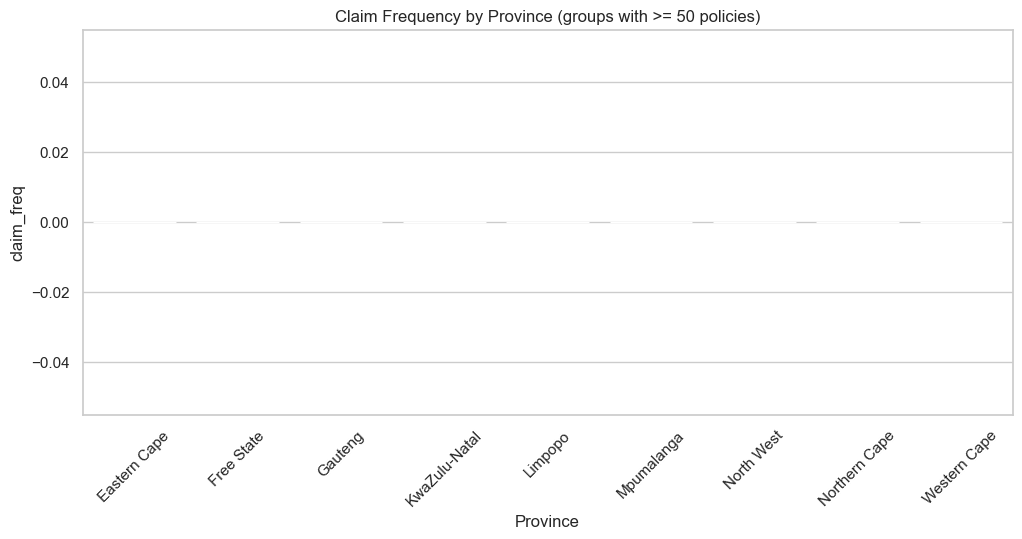

In [25]:
prov_agg["claim_freq"] = prov_agg["n_claims"] / prov_agg["n_policies"]
plt.figure(figsize=(12,5))
sns.barplot(data=prov_agg.sort_values("claim_freq", ascending=False),
            x="Province", y="claim_freq")
plt.xticks(rotation=45)
plt.title(f"Claim Frequency by Province (groups with >= {min_count_prov} policies)")
plt.show()

In [26]:
print("\n===== CHI-SQUARE TEST =====")

# contingency table: [no_claims, has_claims]
contingency = np.vstack([
    prov_agg["n_policies"] - prov_agg["n_claims"],
    prov_agg["n_claims"]
]).T

# check if chi-square can be run
if prov_agg["n_claims"].sum() == 0 or np.any(contingency == 0):
    print("⚠ Chi-square cannot run: dataset has zero claims or at least one group has zero expected claims.")
    chi_result = None
else:
    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    chi_result = {"chi2": chi2, "pvalue": p, "dof": dof}
    print("Chi-square result:", chi_result)
    if p < 0.05:
        print("✅ Reject H0: Significant difference in claim frequency across provinces")
    else:
        print("❌ Fail to reject H0: No significant difference in claim frequency across provinces")



===== CHI-SQUARE TEST =====
⚠ Chi-square cannot run: dataset has zero claims or at least one group has zero expected claims.


In [27]:
summary = prov_agg[["Province", "n_policies", "n_claims", "claim_freq"]]
print("\nProvince-level Claim Summary:")
display(summary)


Province-level Claim Summary:


,Province,n_policies,n_claims,claim_freq
0,Eastern Cape,30336,0,0.0
1,Free State,8099,0,0.0
2,Gauteng,393861,0,0.0
3,KwaZulu-Natal,169781,0,0.0
4,Limpopo,24836,0,0.0
5,Mpumalanga,52718,0,0.0
6,North West,143287,0,0.0
7,Northern Cape,6380,0,0.0
8,Western Cape,170726,0,0.0
